#Cassava Leaf Disease Classification
The purpose of this project is to identify the type of disease present on a Cassava Leaf image.

Cassava is the second largest provider of carbohydrate in Africa, Obviously its importance in food security in Africa cannot be over emphasized. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection in cassava require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This method is labor-intensive, has few reach and expensive, which made it out of the reach for majority of local farmers. To really tackle this  problem, an effective solution is needed. This solution must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

The purpose for this project task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With this, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage and also creating a simple web app where farmers can upload the picture of their plant and the app will tell if the plant has a particular disease and also give farmers advice on what to do based on the diagnose.


In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os

In [6]:
from tensorflow.keras.preprocessing.image import load_img

In [7]:
import json

In [8]:
import os
import shutil
import glob
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetLarge

#First I need to download cassava disease dataset from kaggle

In [9]:
!pip install opendatasets

In [10]:
import opendatasets as od

In [11]:
od.download('https://www.kaggle.com/c/cassava-leaf-disease-classification')

100%|██████████| 5.76G/5.76G [01:51<00:00, 55.4MB/s]



Extracting archive ./cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip to ./cassava-leaf-disease-classification


##let us do a little bit of EDA

In [12]:
train = pd.read_csv('/content/cassava-leaf-disease-classification/train.csv')

In [13]:
train.head(10)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
5,1000837476.jpg,3
6,1000910826.jpg,2
7,1001320321.jpg,0
8,1001723730.jpg,4
9,1001742395.jpg,3


In [14]:
train.describe()

,label
count,21397.000000
mean,2.651914
std,0.988565
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,4.000000


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [16]:
path_labels_info = '/content/cassava-leaf-disease-classification/label_num_to_disease_map.json'

In [17]:
with open(path_labels_info) as jsonFile:
    labels_info = json.load(jsonFile)
    jsonFile.close()
labels_info

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [18]:
train['label'] = train['label'].astype(str)

In [19]:
src_path_train = '/content/cassava-leaf-disease-classification/train_images'


In [20]:
train.label.nunique()

5

In [21]:
distribution = train.groupby('label', as_index=False).agg('count')
distribution

,label,image_id
0,0,1087
1,1,2189
2,2,2386
3,3,13158
4,4,2577


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


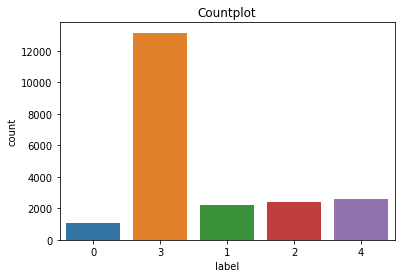

In [22]:
plt.title('Countplot')
sns.countplot(train.label)

From the table above we can see that Cassava Mosaic Disease (CMD) has way more data than other diseases, I need to find a way to balance this data.

##Preprocessing

In [23]:
train2 = pd.read_csv('/content/cassava-leaf-disease-classification/train.csv')

Below I am modifying the first column of my train dataframe into a directory in such a way that I will be able to use created directory to access image data directly from my dataframe.

In [24]:
TRAIN_DIR = '/content/cassava-leaf-disease-classification/train_images/'
train2['image_id'] = train['image_id'].apply(lambda x: f'{TRAIN_DIR}{x}')
train2.head()

,image_id,label
0,/content/cassava-leaf-disease-classification/t...,0
1,/content/cassava-leaf-disease-classification/t...,3
2,/content/cassava-leaf-disease-classification/t...,1
3,/content/cassava-leaf-disease-classification/t...,1
4,/content/cassava-leaf-disease-classification/t...,3


In [25]:
#getting all the indexes where the label disease is 3 i.e Cassava Mosaic Disease (CMD) in a list

CMD=[]
for i in range(len(train2)):
  if train2.label[i] == 3:
    CMD.append(i)

CMD[0:12]



[1, 4, 5, 9, 10, 11, 13, 14, 16, 19, 20, 21]

In [26]:
len(CMD)

13158

In [27]:
# from the above list(CMD) I am selecting 10500 random index to be droped in my train dataframe 
import random
CMD_rand = random.sample(CMD,10500)

In [28]:
# Droping those rows from my dataframe
for i in CMD_rand:
  train2=train2.drop(i)

Now let us do the countplot again, though the data is not balanced, it is still better.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


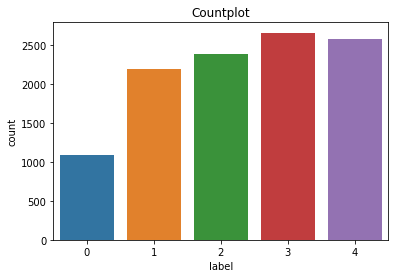

In [29]:
plt.title('Countplot')
sns.countplot(train2.label)

In [30]:
distribution = train2.groupby('label', as_index=False).agg('count')
distribution

,label,image_id
0,0,1087
1,1,2189
2,2,2386
3,3,2658
4,4,2577


In [31]:
immg=train2.image_id.head().tolist()
immg

['/content/cassava-leaf-disease-classification/train_images/1000015157.jpg',
 '/content/cassava-leaf-disease-classification/train_images/1000201771.jpg',
 '/content/cassava-leaf-disease-classification/train_images/100042118.jpg',
 '/content/cassava-leaf-disease-classification/train_images/1000723321.jpg',
 '/content/cassava-leaf-disease-classification/train_images/1000910826.jpg']

In [32]:
train2.shape

(10897, 2)

In [33]:
train2['label'] = train2['label'].astype(str)

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [34]:
data_size = len(train2)
data_size

10897

In [35]:
train_size = 0.7*data_size
val_size = 0.2*data_size
test_size = 0.1*data_size
print('trainsize{},val{},test{}'.format(train_size,val_size,test_size))

trainsize7627.9,val2179.4,test1089.7


In [36]:
os.chdir('/content/cassava-leaf-disease-classification/train_images')


Making separate folders for train, test validation images with classes as sub-folders and transfering the images to their respective folders.

In [37]:
if os.path.isdir('train/Cassava Bacterial Blight (CBB)') is False:
    os.makedirs('train/Cassava Bacterial Blight (CBB)')
    os.makedirs('train/Cassava Brown Streak Disease (CBSD)')
    os.makedirs('train/Cassava Green Mottle (CGM)')
    os.makedirs('train/Cassava Mosaic Disease (CMD)')
    os.makedirs('train/Healthy')
    os.makedirs('valid/Cassava Bacterial Blight (CBB)')
    os.makedirs('valid/Cassava Brown Streak Disease (CBSD)')
    os.makedirs('valid/Cassava Green Mottle (CGM)')
    os.makedirs('valid/Cassava Mosaic Disease (CMD)')
    os.makedirs('valid/Healthy')
    os.makedirs('test/Cassava Bacterial Blight (CBB)')
    os.makedirs('test/Cassava Brown Streak Disease (CBSD)')
    os.makedirs('test/Cassava Green Mottle (CGM)')
    os.makedirs('test/Cassava Mosaic Disease (CMD)')
    os.makedirs('test/Healthy')

    for i,j in enumerate(train2.image_id.tolist()):
      if i <= 7627:
        if train2.iloc[i,1]=='0':
          shutil.move(j, 'train/Cassava Bacterial Blight (CBB)')
        elif train2.iloc[i,1]=='1':
          shutil.move(j, 'train/Cassava Brown Streak Disease (CBSD)')
        elif train2.iloc[i,1]=='2':
          shutil.move(j, 'train/Cassava Green Mottle (CGM)')
        elif train2.iloc[i,1]=='3':
          shutil.move(j, 'train/Cassava Mosaic Disease (CMD)')
        elif train2.iloc[i,1]=='4':
          shutil.move(j, 'train/Healthy')
      if (i > 7627) and (i<=(7627+2180)):
        if train2.iloc[i,1]=='0':
          shutil.move(j, 'valid/Cassava Bacterial Blight (CBB)')
        elif train2.iloc[i,1]=='1':
          shutil.move(j, 'valid/Cassava Brown Streak Disease (CBSD)')
        elif train2.iloc[i,1]=='2':
          shutil.move(j, 'valid/Cassava Green Mottle (CGM)')
        elif train2.iloc[i,1]=='3':
          shutil.move(j, 'valid/Cassava Mosaic Disease (CMD)')
        elif train2.iloc[i,1]=='4':
          shutil.move(j, 'valid/Healthy')   

      if i > (7627+2180):
        if train2.iloc[i,1]=='0':
          shutil.move(j, 'test/Cassava Bacterial Blight (CBB)')
        elif train2.iloc[i,1]=='1':
          shutil.move(j, 'test/Cassava Brown Streak Disease (CBSD)')
        elif train2.iloc[i,1]=='2':
          shutil.move(j, 'test/Cassava Green Mottle (CGM)')
        elif train2.iloc[i,1]=='3':
          shutil.move(j, 'test/Cassava Mosaic Disease (CMD)')
        elif train2.iloc[i,1]=='4':
          shutil.move(j, 'test/Healthy')   
            

os.chdir('../../')

In [38]:
os.listdir('/content/cassava-leaf-disease-classification/train_images')

['2092002351.jpg',
 '115543947.jpg',
 '2508160695.jpg',
 '218822294.jpg',
 '594438051.jpg',
 '1536954784.jpg',
 '3230180504.jpg',
 '2787000269.jpg',
 '315115320.jpg',
 '2703773318.jpg',
 '1184269820.jpg',
 '3518069486.jpg',
 '31203445.jpg',
 '2328232125.jpg',
 '1983593299.jpg',
 '3267768763.jpg',
 '1335214678.jpg',
 '4240296796.jpg',
 '2115499400.jpg',
 '3742361352.jpg',
 '2516383896.jpg',
 '3318576508.jpg',
 '1939567096.jpg',
 '3204119669.jpg',
 '2263381455.jpg',
 '3199885439.jpg',
 '1982984348.jpg',
 '3378264998.jpg',
 '2653161665.jpg',
 '2578622897.jpg',
 '3030489629.jpg',
 '4248695502.jpg',
 '2326806135.jpg',
 '427201982.jpg',
 '544532198.jpg',
 '634792920.jpg',
 '1428048289.jpg',
 '2827746992.jpg',
 '1287994755.jpg',
 '3779397874.jpg',
 '54133224.jpg',
 '202946302.jpg',
 '1650474958.jpg',
 '3963041758.jpg',
 '717221311.jpg',
 '1943999614.jpg',
 '1418640499.jpg',
 '2821478840.jpg',
 '4031511007.jpg',
 '3377483023.jpg',
 '2653660748.jpg',
 '2709553419.jpg',
 '852636262.jpg',
 '27802

Let us view some of the healthy plants

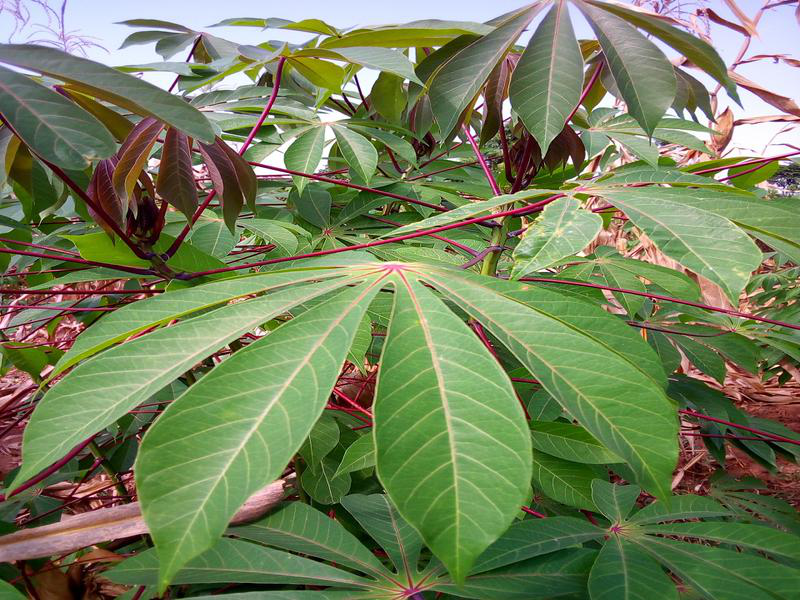

In [39]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/valid/Healthy/3691200692.jpg')
img

In [40]:
x = np.array(img)
x.shape

(600, 800, 3)

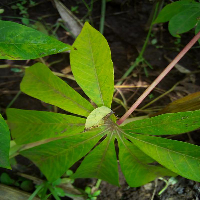

In [41]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/valid/Healthy/3692342611.jpg',target_size=(200,200))
img

In [42]:
x = np.array(img)
x.shape

(200, 200, 3)

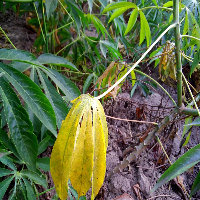

In [43]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/valid/Healthy/3694251978.jpg',target_size=(200,200))
img

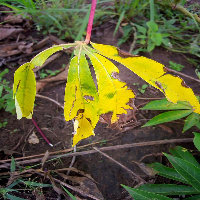

In [44]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/train/Healthy/1001723730.jpg',target_size=(200,200))
img

let us check the ones with cassava bacterial blight

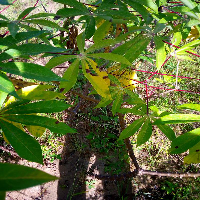

In [45]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/train/Cassava Bacterial Blight (CBB)/1000015157.jpg',target_size=(200,200))
img

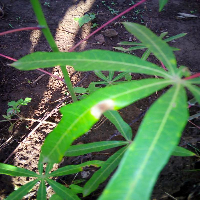

In [46]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/train/Cassava Bacterial Blight (CBB)/1001320321.jpg',target_size=(200,200))
img

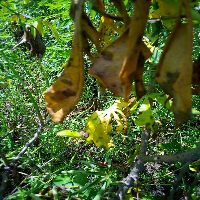

In [47]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/valid/Cassava Bacterial Blight (CBB)/3693127282.jpg',target_size=(200,200))
img

##Cassava Brown Streak Disease

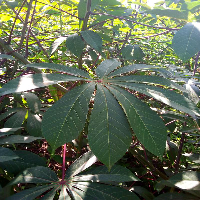

In [48]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/valid/Cassava Brown Streak Disease (CBSD)/3689984405.jpg',target_size=(200,200))
img

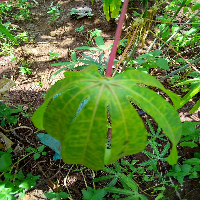

In [49]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/valid/Cassava Brown Streak Disease (CBSD)/3692116146.jpg',target_size=(200,200))
img

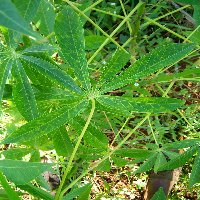

In [50]:
img = load_img('/content/cassava-leaf-disease-classification/train_images/train/Cassava Brown Streak Disease (CBSD)/1000723321.jpg',target_size=(200,200))
img


#Base model
I am going to use transfer learning in training this model, let me first use Xception model and i will try another later

##Training without image augumentation

In [51]:
train_path = '/content/cassava-leaf-disease-classification/train_images/train'
valid_path = '/content/cassava-leaf-disease-classification/train_images/valid'

In [52]:
train_batches =  ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(250,250), batch_size=32)

Found 7628 images belonging to 5 classes.


In [53]:
train_batches.class_indices

{'Cassava Bacterial Blight (CBB)': 0,
 'Cassava Brown Streak Disease (CBSD)': 1,
 'Cassava Green Mottle (CGM)': 2,
 'Cassava Mosaic Disease (CMD)': 3,
 'Healthy': 4}

In [54]:
valid_batches =  ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(250,250), batch_size=32,shuffle=False)

Found 2180 images belonging to 5 classes.


In [55]:
valid_batches.class_indices

{'Cassava Bacterial Blight (CBB)': 0,
 'Cassava Brown Streak Disease (CBSD)': 1,
 'Cassava Green Mottle (CGM)': 2,
 'Cassava Mosaic Disease (CMD)': 3,
 'Healthy': 4}

In [56]:
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

 I am building the model from scratch

In [93]:
inputs = tensorflow.keras.Input(shape=(250, 250, 3))
y = tensorflow.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(inputs)
y = MaxPooling2D(2,2)(y)
y = tensorflow.keras.layers.Flatten()(y)
y= tensorflow.keras.layers.Dense(128,activation='relu')(y)
y= tensorflow.keras.layers.Dense(128,activation='relu')(y)
y = tensorflow.keras.layers.Dropout(0.3)(y)
y= tensorflow.keras.layers.Dense(64,activation='relu')(y)
y= tensorflow.keras.layers.Dense(64,activation='relu')(y)
output= tensorflow.keras.layers.Dense(5, activation='softmax')(y)
model = tensorflow.keras.Model(inputs=inputs, outputs=output)

In [94]:
learning_rate = 0.01
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_batches, epochs=20, validation_data=valid_batches,callbacks=[checkpoint])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


239/239 [==============================] - 100s 413ms/step - loss: 4.8173 - accuracy: 0.2424 - val_loss: 1.5774 - val_accuracy: 0.2454
Epoch 2/20
239/239 [==============================] - 97s 406ms/step - loss: 1.5713 - accuracy: 0.2412 - val_loss: 1.5767 - val_accuracy: 0.2454
Epoch 3/20
239/239 [==============================] - 97s 406ms/step - loss: 1.5707 - accuracy: 0.2400 - val_loss: 1.5764 - val_accuracy: 0.2294
Epoch 4/20
239/239 [==============================] - 97s 406ms/step - loss: 1.5708 - accuracy: 0.2445 - val_loss: 1.5766 - val_accuracy: 0.2294
Epoch 5/20
239/239 [==============================] - 96s 400ms/step - loss: 1.5707 - accuracy: 0.2375 - val_loss: 1.5785 - val_accuracy: 0.2454
Epoch 6/20
239/239 [==============================] - 99s 413ms/step - loss: 1.5708 - accuracy: 0.2420 - val_loss: 1.5772 - val_accuracy: 0.2454
Epoch 7/20
239/239 [==============================] - 97s 405ms/step - loss: 1.5703 - accuracy: 0.2398 - val_loss: 1.5763 - val_accuracy: 0.

##Using transfer learning

In [57]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(250, 250, 3)
)

base_model.trainable = False



inputs = tensorflow.keras.Input(shape=(250, 250, 3))

base = base_model(inputs, training=False)

vectors = tensorflow.keras.layers.GlobalAveragePooling2D()(base)

outputs = tensorflow.keras.layers.Dense(5, activation='softmax')(vectors)

model = tensorflow.keras.Model(inputs, outputs)

83697664/83683744 [==============================] - 1s 0us/step


In [58]:
learning_rate = 0.01
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_batches, epochs=50, validation_data=valid_batches,callbacks=[checkpoint])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


239/239 [==============================] - ETA: 0s - loss: 1.3159 - accuracy: 0.4950

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


239/239 [==============================] - 163s 629ms/step - loss: 1.3159 - accuracy: 0.4950 - val_loss: 1.2689 - val_accuracy: 0.5372
Epoch 2/50
239/239 [==============================] - 133s 555ms/step - loss: 1.1249 - accuracy: 0.5701 - val_loss: 1.1682 - val_accuracy: 0.5555
Epoch 3/50
239/239 [==============================] - 134s 559ms/step - loss: 1.0655 - accuracy: 0.5992 - val_loss: 1.3626 - val_accuracy: 0.5339
Epoch 4/50
239/239 [==============================] - 132s 552ms/step - loss: 1.0012 - accuracy: 0.6211 - val_loss: 1.3878 - val_accuracy: 0.5376
Epoch 5/50
239/239 [==============================] - 130s 543ms/step - loss: 0.9284 - accuracy: 0.6439 - val_loss: 1.2611 - val_accuracy: 0.5555
Epoch 6/50
239/239 [==============================] - 129s 541ms/step - loss: 0.9165 - accuracy: 0.6483 - val_loss: 1.4615 - val_accuracy: 0.5271
Epoch 7/50
239/239 [==============================] - 134s 560ms/step - loss: 0.8671 - accuracy: 0.6647 - val_loss: 1.6932 - val_accura

In [59]:
class_list = ['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

In [60]:
fullname= '/content/cassava-leaf-disease-classification/train_images/test/Cassava Brown Streak Disease (CBSD)/600736721.jpg'

In [61]:
img = load_img(fullname, target_size=(250, 250))

In [62]:
X = np.array(img)
X.shape

(250, 250, 3)

In [63]:
X = np.array([X])

In [64]:
X = X/255

In [ ]:
pred = model.predict(X)
pred

##Training with image augumentation

In [65]:
plt.plot(history.history['val_accuracy'], label='val')
plt.plot(history.history['accuracy'], label='train')
plt.xticks(np.arange(10))
plt.legend()

NameError: ignored

In [66]:
train_gen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [67]:
train_ds = train_gen2.flow_from_directory(directory=train_path, target_size=(250,250), batch_size=32)

Found 7628 images belonging to 5 classes.


In [68]:
history2 = model.fit(train_ds, epochs=50, validation_data=valid_batches)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


239/239 [==============================] - 257s 1s/step - loss: 1.5018 - accuracy: 0.4223 - val_loss: 1.3047 - val_accuracy: 0.4991
Epoch 2/50
239/239 [==============================] - 225s 942ms/step - loss: 1.3342 - accuracy: 0.4894 - val_loss: 1.2443 - val_accuracy: 0.5376
Epoch 3/50
239/239 [==============================] - 225s 939ms/step - loss: 1.3630 - accuracy: 0.4916 - val_loss: 1.3254 - val_accuracy: 0.5294
Epoch 4/50
239/239 [==============================] - 225s 943ms/step - loss: 1.3340 - accuracy: 0.5018 - val_loss: 1.2931 - val_accuracy: 0.5312
Epoch 5/50
239/239 [==============================] - 225s 941ms/step - loss: 1.3223 - accuracy: 0.5050 - val_loss: 1.7408 - val_accuracy: 0.4495
Epoch 6/50
239/239 [==============================] - 225s 942ms/step - loss: 1.2516 - accuracy: 0.5215 - val_loss: 1.3990 - val_accuracy: 0.5266
Epoch 7/50
239/239 [==============================] - 227s 948ms/step - loss: 1.2858 - accuracy: 0.5241 - val_loss: 1.5999 - val_accuracy:

picking a random image from my test images and predicting to see if it will give a correct prediction 

In [69]:
fullname= '/content/cassava-leaf-disease-classification/train_images/test/Cassava Brown Streak Disease (CBSD)/600736721.jpg'

In [70]:
img = load_img(fullname, target_size=(250, 250))

In [71]:
X = np.array(img)
X.shape

(250, 250, 3)

In [72]:
X = np.array([X])

In [73]:
X = X/255

In [74]:
pred = model.predict(X)
pred

array([[7.0015056e-09, 9.9998569e-01, 6.5042502e-07, 1.6277312e-08,
        1.3589695e-05]], dtype=float32)

In [75]:
class_list[np.argmax(pred)]

'Cassava Brown Streak Disease (CBSD)'

Let us add more layers to our model

In [78]:
inputs = tensorflow.keras.Input(shape=(250, 250, 3))

base = base_model(inputs, training=False)

vectors = tensorflow.keras.layers.GlobalAveragePooling2D()(base)

inner1 =  tensorflow.keras.layers.Dense(120, activation='relu')(vectors)

inner2 = tensorflow.keras.layers.Dense(120, activation='relu')(inner1)

drop = tensorflow.keras.layers.Dropout(0.3)(inner2)

outputs = tensorflow.keras.layers.Dense(5, activation='softmax')(inner2)

model2 = tensorflow.keras.Model(inputs, outputs)

In [79]:
learning_rate = 0.01
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)

model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [80]:
history3 = model2.fit(train_ds, epochs=20, validation_data=valid_batches,callbacks=[checkpoint])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


239/239 [==============================] - ETA: 0s - loss: 1.4220 - accuracy: 0.3667

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


239/239 [==============================] - 230s 946ms/step - loss: 1.4220 - accuracy: 0.3667 - val_loss: 1.3180 - val_accuracy: 0.4307
Epoch 2/20
239/239 [==============================] - 228s 952ms/step - loss: 1.2861 - accuracy: 0.4352 - val_loss: 1.1966 - val_accuracy: 0.4972
Epoch 3/20
239/239 [==============================] - 229s 957ms/step - loss: 1.2577 - accuracy: 0.4616 - val_loss: 1.1941 - val_accuracy: 0.4982
Epoch 4/20
239/239 [==============================] - 228s 955ms/step - loss: 1.2065 - accuracy: 0.4927 - val_loss: 1.1710 - val_accuracy: 0.5165
Epoch 5/20
239/239 [==============================] - 226s 944ms/step - loss: 1.2057 - accuracy: 0.4940 - val_loss: 1.1643 - val_accuracy: 0.5133
Epoch 6/20
239/239 [==============================] - 226s 947ms/step - loss: 1.1687 - accuracy: 0.5176 - val_loss: 1.1395 - val_accuracy: 0.5216
Epoch 7/20
239/239 [==============================] - 228s 953ms/step - loss: 1.1687 - accuracy: 0.5278 - val_loss: 1.1640 - val_accura

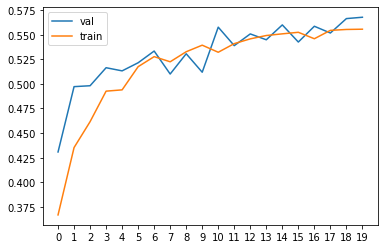

In [84]:
plt.plot(history3.history['val_accuracy'], label='val')
plt.plot(history3.history['accuracy'], label='train')
plt.xticks(np.arange(20))
plt.legend()

In [85]:
fullname= '/content/cassava-leaf-disease-classification/train_images/test/Cassava Brown Streak Disease (CBSD)/600736721.jpg'

In [86]:
img = load_img(fullname, target_size=(250, 250))

In [87]:
X = np.array(img)
X.shape

(250, 250, 3)

In [88]:
X = np.array([X])

In [89]:
X = X/255

In [90]:
pred = model2.predict(X)
pred

array([[1.3341507e-05, 9.9996543e-01, 3.2239650e-06, 8.0117807e-06,
        9.9620693e-06]], dtype=float32)